# # 텍스트 유사도
(p.229) 생략 - 영어 예제

# 챗봇 (p.278)

중요한건 NER 객체 어쩌구랑 묘사 단어를 얼마나 잘 뽑느냐가 궁금하다고 하지 않았었나 ?

(p.390) 참고

p.401

# 버트를 활용한 한국어 개체명 인식 모델
## 개체명 인식 (NER : Named Entity Recognition)
문맥을 파악해서 인명, 기관명, 지명 등과 같은 문장 또는 문서에서 특장한 의미를 가지고 있는 단어 또는 어구를 인식하는 과정을 말한다. 감정 분류 및 유사도 분류와 맥락은 거의 비슷하나 마지막 히든 벡터값을 사용하는 방법과는 다르게 문장의 모든 입력 값을 개체명으로 예측해야 하기 때문에 모든 은닉 벡터 값을 활용한다.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
import tensorflow as tf

In [2]:
DATA_IN_PATH = 'c:/BERT/data_in/'
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, "NER", 'train.tsv')
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, "NER", 'test.tsv')
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, "NER", 'label.tsv')

In [3]:
def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, 'r', encoding='utf-8') as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split('\t')
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
test_sentences, test_labels = read_file(DATA_TEST_PATH)
ner_sentences = train_sentences + test_sentences
ner_labels = train_labels + test_labels

ner_dict = {"sentence":ner_sentences, "label":ner_labels}
ner_df = pd.DataFrame(ner_dict)

In [4]:
print(f'전체 ner_train_data 개수 : {len(ner_df)}')
ner_df.head(5)

전체 ner_train_data 개수 : 90000


,sentence,label
0,"금석객잔 여러분, 감사드립니다 .",ORG-B O O O
1,이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .,PER-B O O O TIM-B TIM-I CVL-B O O O O O
2,7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...,EVT-B EVT-I PER-B PER-I O LOC-B O EVT-B CVL-B O O
3,스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...,LOC-B NUM-B NUM-I O O O O O O O O O O O O O CV...
4,보니까 저 옆에 사조가 있어요 .,O O O O O O


개체명 인식에서 기존의 분류 문제와는 다른 BIO 태깅을 활용한다.  
B(Begin) - I(Inside) - O(Outside)   
개체명 시작 - 내부 - 개체명이 아닌 부분  
각 태깅은 문장에서 개체명으로서 의미 있는 토큰들의 위치를 인식할 수 있게 도와준다.  

# 한국어 개체명 텍스트 분석

In [5]:
train_set = pd.Series(ner_df['sentence'].tolist()).astype(str)
train_set.head()

0                                   금석객잔 여러분, 감사드립니다 .
1              이기범 한두 쪽을 먹고 10분 후쯤 화제인을 먹는 것이 좋다고 한다 .
2    7-8위 결정전에서 김중배 무스파타(샌안토니오)가 참은 법국을 누르고 유럽축구선수권...
3    스코틀랜드의 한 마을에서 보통하게 살고 있다는 이 기혼 남성의 시조가 유튜브 등에서...
4                                   보니까 저 옆에 사조가 있어요 .
dtype: object

In [6]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

print(f"문장 단어 개수 최대 값 : {np.max(train_word_counts)}")
print(f"문장 단어 개수 평균 값 : {np.mean(train_word_counts)}")
print(f"문장 단어 개수 표준편차 : {np.std(train_word_counts)}")
print(f"문장 단어 개수 중간값 : {np.median(train_word_counts)}")
print(f"문장 단어 개수 제1사분위 : {np.percentile(train_word_counts, 25)}")
print(f"문장 단어 개수 제3사분위 : {np.percentile(train_word_counts, 75)}")
print(f"문장 단어 개수 99 퍼센트 : {np.percentile(train_word_counts, 99)}")

문장 단어 개수 최대 값 : 175
문장 단어 개수 평균 값 : 11.817455555555556
문장 단어 개수 표준편차 : 7.0330805462652854
문장 단어 개수 중간값 : 10.0
문장 단어 개수 제1사분위 : 7.0
문장 단어 개수 제3사분위 : 15.0
문장 단어 개수 99 퍼센트 : 35.0


Text(0, 0.5, 'Probability')

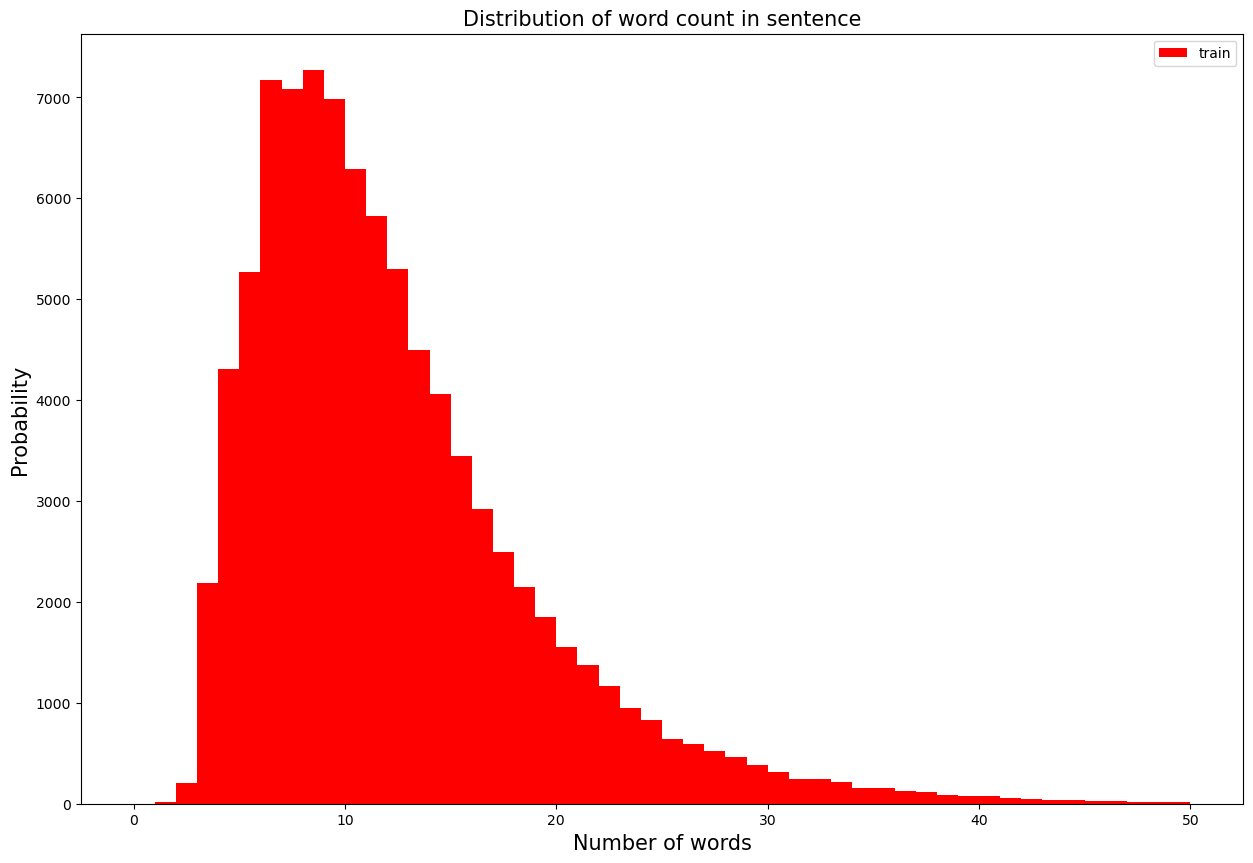

In [7]:
plt.figure(figsize=(15,10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', label='train')
plt.title('Distribution of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

{'whiskers': [<matplotlib.lines.Line2D at 0x28f888227c0>,
 'caps': [<matplotlib.lines.Line2D at 0x28f88822d60>,
 'boxes': [<matplotlib.lines.Line2D at 0x28f888224f0>],
 'medians': [<matplotlib.lines.Line2D at 0x28f88834340>],
 'fliers': [<matplotlib.lines.Line2D at 0x28f888348e0>],
 'means': [<matplotlib.lines.Line2D at 0x28f88834610>]}

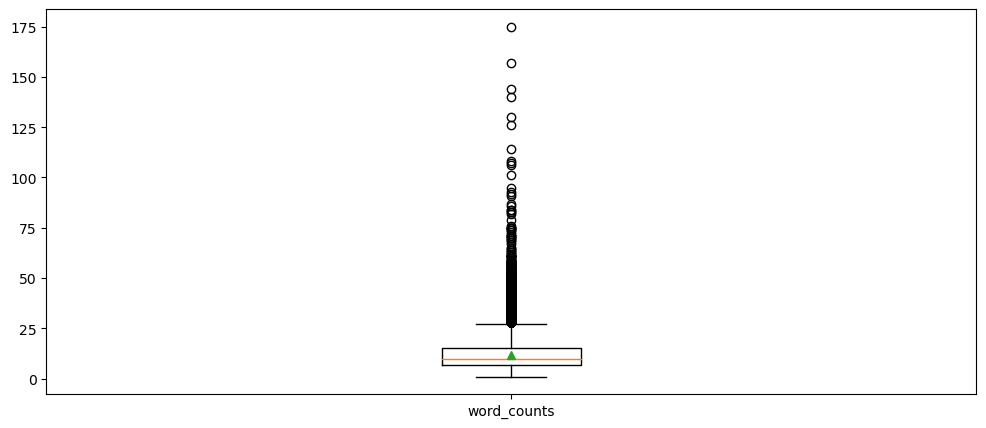

In [8]:
plt.figure(figsize=(12,5))
plt.boxplot(train_word_counts, labels=['word_counts'], showmeans=True)

In [9]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir="bert_ckpt", do_lower_case=False)

In [10]:
train_bert_token_couonts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))
print(f"문장 token 개수 최대 값 : {np.max(train_bert_token_couonts)}")
print(f"문장 token 개수 평균 값 : {np.mean(train_bert_token_couonts)}")
print(f"문장 token 개수 표준편차 : {np.std(train_bert_token_couonts)}")
print(f"문장 token 개수 중간값 : {np.median(train_bert_token_couonts)}")
print(f"문장 token 개수 제1사분위 : {np.percentile(train_bert_token_couonts, 25)}")
print(f"문장 token 개수 제3사분위 : {np.percentile(train_bert_token_couonts, 75)}")
print(f"문장 token 개수 99 퍼센트 : {np.percentile(train_bert_token_couonts, 99)}")

문장 token 개수 최대 값 : 850
문장 token 개수 평균 값 : 33.61855555555555
문장 token 개수 표준편차 : 22.756686199938347
문장 token 개수 중간값 : 28.0
문장 token 개수 제1사분위 : 19.0
문장 token 개수 제3사분위 : 41.0
문장 token 개수 99 퍼센트 : 111.0


{'whiskers': [<matplotlib.lines.Line2D at 0x28f895a1040>,
 'caps': [<matplotlib.lines.Line2D at 0x28f895a15e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x28f89590d30>],
 'medians': [<matplotlib.lines.Line2D at 0x28f895a1b80>],
 'fliers': [<matplotlib.lines.Line2D at 0x28f895ae160>],
 'means': [<matplotlib.lines.Line2D at 0x28f895a1e50>]}

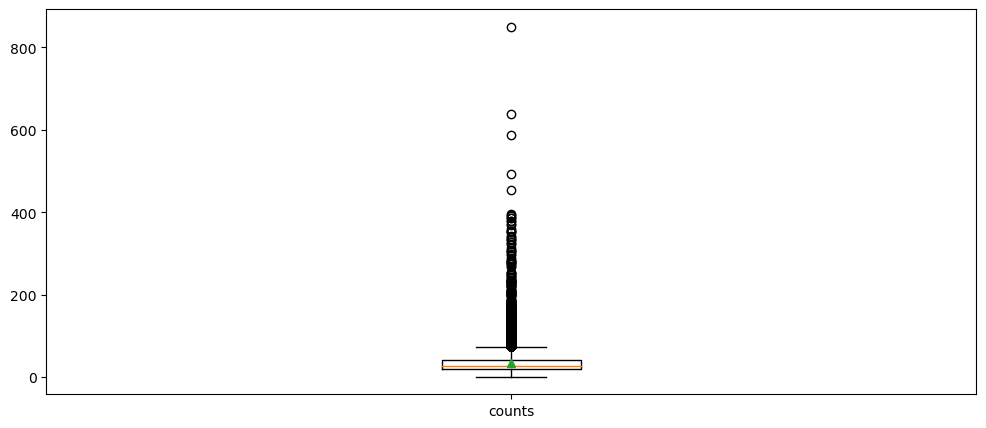

In [11]:
plt.figure(figsize=(12,5))
plt.boxplot(train_bert_token_couonts, labels=['counts'], showmeans=True)

# NER 데이터 전처리
한국어 개체명 인식 데이터를 버트로 학습하려면 데이터 구조를 변경할 필요가 있다. 기존의 학습 데이터 구조의 라벨은 문장의 띄어쓰기 단위로 나눠져 있다. 따라서 버트 토크나이저를 활용하는 경우 기존 데이터 구조와 달라지기 때문에 토큰에 맞게 재배치해야 한다.  
-> 기존과 다르게 토큰이 분해되므로 다른 태스크와 다르게 해당 분류에 맞게 각 라벨 데이터를 수정하는 추가 작업이 필요하다. 

In [12]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

BATCH_SIZE = 32
NUM_EPOCHS = 3
MAX_LEN = 111   ## EDA에서 추출된 Max Length
DATA_IN_PATH = 'C:/BERT/data_in/'
DATA_OUT_PATH = 'C:/BERT/data_out/'

In [13]:
## 데이터 전처리 준비
DATA_TRAIN_PATH = os.path.join(DATA_IN_PATH, 'NER', 'train.tsv')
DATA_LABEL_PATH = os.path.join(DATA_IN_PATH, 'NER', 'label.txt')
DATA_TEST_PATH = os.path.join(DATA_IN_PATH, 'NER', 'test.tsv')

def read_file(input_path):
    """Read tsv file, and return words and label as list"""
    with open(input_path, 'r', encoding='utf-8') as f:
        sentences = []
        labels = []
        for line in f:
            split_line = line.strip().split('\t')
            sentences.append(split_line[0])
            labels.append(split_line[1])
        return sentences, labels

train_sentences, train_labels = read_file(DATA_TRAIN_PATH)
train_ner_dict = {"sentence":train_sentences, "label":train_labels}
train_ner_df = pd.DataFrame(train_ner_dict)

test_sentences, test_labels = read_file(DATA_TEST_PATH)
test_ner_dict = {"sentence":test_sentences, "label":test_labels}
test_ner_df = pd.DataFrame(test_ner_dict)

print(f'개체명 인식 학습 데이터 개수 : {len(train_ner_df)}')
print(f'개체명 인식 테스트 데이터 개수 : {len(test_ner_df)}')

개체명 인식 학습 데이터 개수 : 81000
개체명 인식 테스트 데이터 개수 : 9000


In [14]:
# Label 불러오기
def get_labels(label_path):
    return [
        label.strip()
        for label in open(os.path.join(label_path), 'r', encoding='utf-8')
    ]

ner_labels = get_labels(DATA_LABEL_PATH)

print(f'개체명 인식 라벨 개수 : {len(ner_labels)}')

개체명 인식 라벨 개수 : 30


In [15]:
## 버트 토크나이저 설정
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir="bert_ckpt", do_lower_case=False)

pad_token_id = tokenizer.pad_token_id
pad_token_label_id = 0
cls_token_label_id = 0
sep_token_label_id = 0

In [16]:
def bert_tokenizer(sent, MAX_LEN):
    encoded_dict = tokenizer.encode_plus(text = sent, add_special_tokens = True, max_length = MAX_LEN, pad_to_max_length = True, return_attention_mask = True, truncation=True)
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']    
    token_type_id = encoded_dict['token_type_ids']
    return input_id, attention_mask, token_type_id
# (p.413)

In [17]:
def convert_label(words, labels_idx, ner_begin_label, max_seq_len):
    tokens = []
    label_ids = []
    for word, slot_label in zip(words, labels_idx):
        word_tokens = tokenizer.tokenize(word)
        if not word_tokens:
            word_tokens = [unk_token]
        tokens.extend(word_tokens)
        
        if int(slot_label) in ner_begin_label:
            label_ids.extend([int(slot_label)] + [int(slot_label) + 1] * (len(word_tokens) - 1))
        else:
            label_ids.extend([int(slot_label)] * len(word_tokens))
            
    special_tokens_count = 2
    if len(label_ids) > max_seq_len - special_tokens_count:
        label_ids = label_ids[: (max_seq_len - special_tokens_count)]
        
    label_ids += [sep_token_label_id]
    
    label_ids = [cls_token_label_id] + label_ids
    
    padding_length = max_seq_len - len(label_ids)
    label_ids = label_ids + ([pad_token_label_id] * padding_length)
    
    return label_ids

In [18]:
ner_begin_label = [ner_labels.index(begin_label) for begin_label in ner_labels if 'B' in begin_label]

def create_inputs_targets(df):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    label_list = []
    
    for i, data in enumerate(df[['sentence', 'label']].values):
        sentence, labels = data
        words = sentence.split()
        labels = labels.split()
        labels_idx = []
        
        for label in labels:
            labels_idx.append(ner_labels.index(label)
                             if label in ner_labels
                             else ner_labels.index("UNK"))
        assert len(words) == len(labels_idx)
        
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)
        convert_label_id = convert_label(words, labels_idx, ner_begin_label, MAX_LEN)
        
        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        label_list.append(convert_label_id)
        
    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)
    label_list = np.asarray(label_list, dtype=int)   ## 라벨 토크나이징 리스트
    inputs = (input_ids, attention_masks, token_type_ids)
    
    return inputs, label_list

train_inputs, train_labels = create_inputs_targets(train_ner_df)
test_inputs, test_labels = create_inputs_targets(test_ner_df)

C:\Users\user\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2304: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal in

In [ ]:
class TFBertNERClassifier(tf.keras.Model):
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertNERClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.num_class = num_class
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class,
                                               kernel_initializer=tf.keras.initializers.TruncatedNormal(
                                               self.bert.config.initializer_range), name="ner_classifier",)
        
    def call(self, inputs, attention_mask=None, token_type_ids = None, training=False) :
        outputs = self.bert(
        inputs, attention_mask=attention_mask, token_type_ids = token_type_ids)
        sequence_output = outputs[0]
        sequence_output = self.dropout(sequence_output, training=training)
        logits = self.classifier(sequence_output)
        
        return logits
    
ner_model = TFBertNERClassifier(model_name='bert-base-multilingual-cased', dir_path='bert_ckpt', num_class=len(ner_labels))

In [ ]:
def compute_loss(labels, logits):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction=tf.keras.losses.Reduction.NONE)
    active_loss = tf.reshape(labels, (-1,)) != 0
    reduced_logits = tf.boolean_mask(tf.reshape(logits, (-1, shape_list[2]))
                                    )